In [2]:
import qiskit
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from qiskit.providers.aer import AerSimulator

In [3]:
#input length of qubits
n = 3

In [4]:
#define oracle for algorithm
circ = QuantumCircuit(n+1,n)
s = '001' #hidden bit string

s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        circ.i(q)
    else:
        circ.cx(q, n)

In [5]:
#define full algorithm
circuit = QuantumCircuit(n+1,n)
#apply Hadamard at beginning
for i in range(n):
    circuit.h(i)

#create - state on q3
circuit.x(3)
circuit.h(3)
circuit.barrier()

#apply oracle on circuit
circuit += circ
circuit.barrier()

#apply hadamrad on output 
for i in range(n):
    circuit.h(i)
    
circuit.barrier()

#measure qubits
for i in range(n):
    circuit.measure(i,i)

circuit.draw()

/var/folders/05/9y6gplnj7kg_9m62mlq2tlqr0000gn/T/ipykernel_22338/386505763.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circuit += circ


┌───┐      ░            ░ ┌───┐ ░ ┌─┐      
q_0: ┤ H ├──────░───■────────░─┤ H ├─░─┤M├──────
     ├───┤      ░   │  ┌───┐ ░ ├───┤ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼──┤ I ├─░─┤ H ├─░──╫─┤M├───
     ├───┤      ░   │  ├───┤ ░ ├───┤ ░  ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├─░─┤ H ├─░──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘ ░ └───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├──────░───────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘      ░       ░  ║  ║  ║ 
c_0: ═══════════════════════════════════╩══╬══╬═
                                           ║  ║ 
c_1: ══════════════════════════════════════╩══╬═
                                              ║ 
c_2: ═════════════════════════════════════════╩═

In [24]:
def bv_oracle(n,b):
    # We need to make a QuantumCircuit object to return
    # We need a circuit with n qubits, plus one auxiliary qubit
    bv_oracle = QuantumCircuit(n+1)
    #if b='random' generate a random input bit string of length n
    if b == 'random':
        b = np.random.randint(1,2**n)
        b_str = format(b, '0'+str(n)+'b')
        b_str = b_str[::-1] # reverse b_str to fit qiskit's qubit ordering
        for q in range(n):
            if b_str[q] == '0':
                bv_oracle.i(q)
            else:
                bv_oracle.cx(q, n)
    #if b (the input bit string) is defined then use it 
    
    else:
        b= b[::-1] # reverse b_str to fit qiskit's qubit ordering
        for p in range(n):
            #if bit string is 0 apply identity
            if b[p] == '0':
                bv_oracle.i(p)
            #if the ith bit string is 1 apply CNOT from the ith qubit (control) to the auxiliary qubit (target)
            else:
                bv_oracle.cx(p, n)
    oracle_gate = bv_oracle.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [25]:
def bv_algorithm(oracle,n):
    # We need a circuit with n qubits, plus one auxiliary qubit
    # Also need n classical bits to write the output to
    bv_circuit = QuantumCircuit(n+1, n)

    # put auxiliary in state |->
    bv_circuit.h(n)
    bv_circuit.z(n)

    # Apply Hadamard gates before querying the oracle
    for i in range(n):
        bv_circuit.h(i)
    
    # Apply barrier 
    bv_circuit.barrier()
    
    # Let's append the oracle gate to our circuit:
    bv_circuit.append(oracle, range(n+1))
    
    # Apply barrier 
    bv_circuit.barrier()

    #Apply Hadamard gates after querying the oracle
    for i in range(n):
        bv_circuit.h(i)

    # Measurement
    for i in range(n):
        bv_circuit.measure(i, i)

    return bv_circuit
    
    

In [55]:
n=4
oracle_gate = bv_oracle(n, '0010')
bv_circuit = bv_algorithm(oracle_gate, n)
bv_circuit.draw()


┌───┐      ░ ┌─────────┐ ░ ┌───┐┌─┐         
q_0: ┤ H ├──────░─┤0        ├─░─┤ H ├┤M├─────────
     ├───┤      ░ │         │ ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├──────░─┤1        ├─░─┤ H ├─╫─┤M├──────
     ├───┤      ░ │         │ ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├──────░─┤2 Oracle ├─░─┤ H ├─╫──╫─┤M├───
     ├───┤      ░ │         │ ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░─┤3        ├─░─┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐ ░ │         │ ░ └───┘ ║  ║  ║ └╥┘
q_4: ┤ H ├┤ Z ├─░─┤4        ├─░───────╫──╫──╫──╫─
     └───┘└───┘ ░ └─────────┘ ░       ║  ║  ║  ║ 
c_0: ═════════════════════════════════╩══╬══╬══╬═
                                         ║  ║  ║ 
c_1: ════════════════════════════════════╩══╬══╬═
                                            ║  ║ 
c_2: ═══════════════════════════════════════╩══╬═
                                               ║ 
c_3: ══════════════════════════════════════════╩═

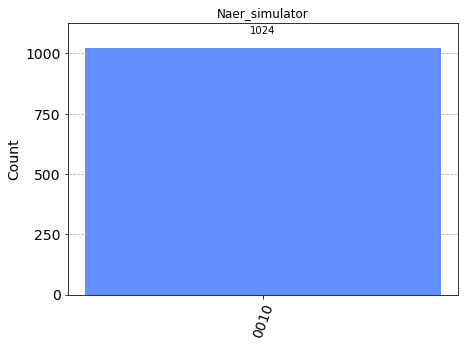

In [56]:
#simulate the case of 4 input qubits on the noisless simulator
#then simulate on 2 different quantum computers with noise 

#noisless simulations

simulator = Aer.get_backend('aer_simulator_stabilizer')
circ = transpile(bv_circuit, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)

plot_histogram(counts, title="Naer_simulator")

/var/folders/05/9y6gplnj7kg_9m62mlq2tlqr0000gn/T/ipykernel_22338/1556141948.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo,FakeCasablanca


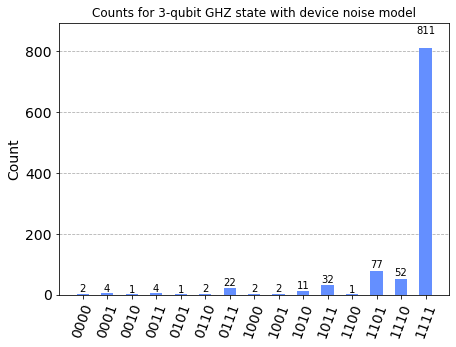

In [51]:
#use of noisy simulator
from qiskit.test.mock import FakeVigo,FakeCasablanca
device_backend = FakeVigo()

# Transpile the circuit for the noisy basis gates
sim_vigo = AerSimulator.from_backend(device_backend)
tcirc = transpile(bv_circuit, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")




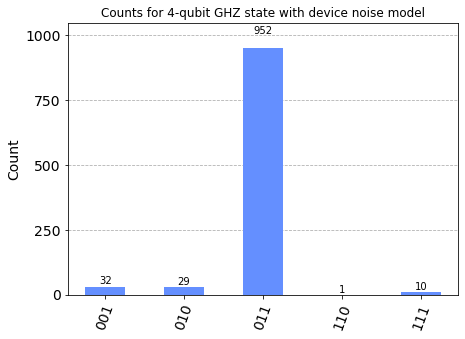

In [52]:
device_backend = FakeCasablanca()

# Transpile the circuit for the noisy basis gates
sim_casa = AerSimulator.from_backend(device_backend)
tcirc = transpile(dj_circuit, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_casa.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 4-qubit GHZ state with device noise model")


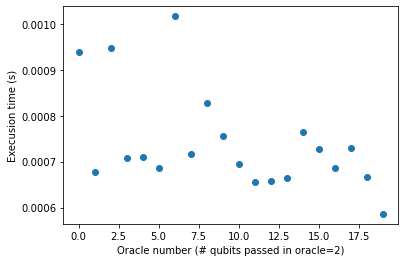

In [53]:
import time
import matplotlib.pyplot as plt

#calculate execution time for different oracles 

time_for_diff_oracles=[]
for i in range(20):
    start_time = time.time()
    n=2
    b = np.random.randint(1,2**n)
    b_str = format(b, '0'+str(n)+'b')
    oracle_gate = bv_oracle(n,b_str)
    bv_circuit = bv_algorithm(oracle_gate, n)
    time_for_diff_oracles.append(time.time()-start_time)
    
plt.plot(range(20),time_for_diff_oracles,"o")
plt.xlabel("Oracle number (# qubits passed in oracle=2)")
plt.ylabel("Execusion time (s)")
plt.savefig("oracle_execusion_bv.pdf")
plt.show()

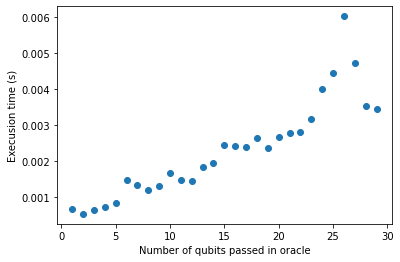

In [54]:
#calculate execution time for different number of input qubits

time_for_diff_n=[]
for i in np.arange(1,30,1):
    start_time = time.time()
    n=i
    b = np.random.randint(1,2**n)
    b_str = format(b, '0'+str(n)+'b')
    oracle_gate = bv_oracle(n,b_str)
    bv_circuit = bv_algorithm(oracle_gate, n)
    time_for_diff_n.append(time.time()-start_time)
    
plt.plot(np.arange(1,30,1),time_for_diff_n,"o")
plt.xlabel("Number of qubits passed in oracle")
plt.ylabel("Execusion time (s)") 
plt.savefig("n_qubit_execusion_bv.pdf")
plt.show()